In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchmetrics.classification import BinaryAccuracy

from distreg import distributions
from distreg.feature_encoder import PolynomialEncoder, RffEncoder

ImportError: cannot import name 'PolynomialEncoder' from 'distreg.feature_encoder' (unknown location)

In [2]:
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device)

cpu


### Generate some distributions and sample from them

In [4]:
n_distributions = 700
normals_mu_range = (0, 10)
normals_sigma_range = (0, 10)

samples_per_dist = 2000


### Distribution mean embeddings

In [7]:
def gen_mean_embeddings(dist_samples, encoder):
    n_distributions = len(dist_samples.keys())
    n_features = encoder.get_n_features()

    mean_embeddings = torch.empty((n_distributions, n_features))
    for idx, samples in dist_samples.items():
        features = encoder.encode_features(samples)
        mean_embeddings[idx] = torch.mean(features, dim=0)
    return mean_embeddings


In [8]:
# Generate (n_distributions,) normal distributions with mean and std
# uniformly sampled in the preset ranges
normal_dists = gen_normals(n_distributions, normals_mu_range, normals_sigma_range)

# Generate (samples_per_dist, ) 1D samples for each distribution
normal_samples = gen_normal_samples(normal_dists, samples_per_dist)

# Binary classification criteria - std greater than a threshold
class_sigma_threshold = 3.3

# Classify normals based on sigma > threshold
normal_labels = (normal_dists[:, 1] > -((normal_dists[:, 0] - 5) ** 2) + 13).type(
    torch.float32
)
# normal_labels = (normal_dists[:, 1] > class_sigma_threshold).type(torch.float32)

<AxesSubplot: >

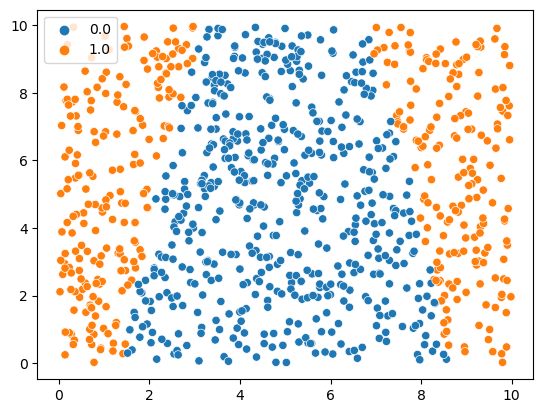

In [9]:
sns.scatterplot(x=normal_dists[:, 0], y=normal_dists[:, 1], hue=normal_labels)

#### Distribution Dataset

In [10]:
class DistributionDataset(Dataset):
    def __init__(self, mean_embeddings, labels, dist_data):
        self.mean_embeddings = mean_embeddings.clone()
        self.labels = labels.clone()
        self.dist_data = dist_data.clone()

    def __len__(self):
        return len(self.mean_embeddings)

    def __getitem__(self, idx):
        return self.mean_embeddings[idx], self.labels[idx], self.dist_data[idx]

In [12]:
n_features = 25
n_dim = 1

train_ratio = 0.7

#### Initialize mean embeddings dataset

In [13]:
rff_encoder = RffEncoder(
    n_features, n_dim, kernel="laplacian", coeff=2.5, lengthscale=1.1)
rff_encoder.gen_features()

mean_embeddings = gen_mean_embeddings(normal_samples, rff_encoder)

dataset = DistributionDataset(mean_embeddings, normal_labels, normal_dists)

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_ratio, 1 - train_ratio]
)

print(len(train_dataset), len(test_dataset))


630 270


In [14]:
epochs = 15
lr = 0.01

criterion = nn.BCELoss(reduction="sum")

### Logistic Regressor

In [15]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return torch.sigmoid(out)

In [16]:
model = LogisticRegression(n_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [17]:
def train_model(model, optimizer, train_dataset, test_dataset, epochs, verbose=False):
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    train_size = len(train_loader.dataset)
    test_size = len(test_loader.dataset)

    train_losses = []
    test_losses = []

    for e in range(epochs):
        train_loss = 0.0
        for (_, (data, labels, _)) in enumerate(train_loader):
            data = data.to(device)

            y = model(data).flatten()
            loss = criterion(y, labels)

            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            test_loss = 0.0
            for _, (test_data, labels_test, _) in enumerate(test_loader):
                test_data = test_data.to(device)
                y_test = model(test_data).flatten()
                loss = criterion(y_test, labels_test)
                test_loss += loss.item()

        train_loss /= train_size
        test_loss /= test_size

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if e % 50 == 0 and verbose:
            print("Epoch: %d, training loss = %.4f" % (e, train_loss))

    return train_losses, test_losses

In [18]:
model = LogisticRegression(n_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

train_losses, test_losses = train_model(
    model, optimizer, train_dataset, test_dataset, 4000, verbose=True
)

Epoch: 0, training loss = 0.6609
Epoch: 50, training loss = 0.4886
Epoch: 100, training loss = 0.4635
Epoch: 150, training loss = 0.4496
Epoch: 200, training loss = 0.4406
Epoch: 250, training loss = 0.4347
Epoch: 300, training loss = 0.4305
Epoch: 350, training loss = 0.4275
Epoch: 400, training loss = 0.4253
Epoch: 450, training loss = 0.4235
Epoch: 500, training loss = 0.4220
Epoch: 550, training loss = 0.4208
Epoch: 600, training loss = 0.4197
Epoch: 650, training loss = 0.4188
Epoch: 700, training loss = 0.4179
Epoch: 750, training loss = 0.4172
Epoch: 800, training loss = 0.4165
Epoch: 850, training loss = 0.4159
Epoch: 900, training loss = 0.4153
Epoch: 950, training loss = 0.4148
Epoch: 1000, training loss = 0.4143
Epoch: 1050, training loss = 0.4139
Epoch: 1100, training loss = 0.4135
Epoch: 1150, training loss = 0.4131
Epoch: 1200, training loss = 0.4127
Epoch: 1250, training loss = 0.4124
Epoch: 1300, training loss = 0.4120
Epoch: 1350, training loss = 0.4117
Epoch: 1400, tr

<AxesSubplot: >

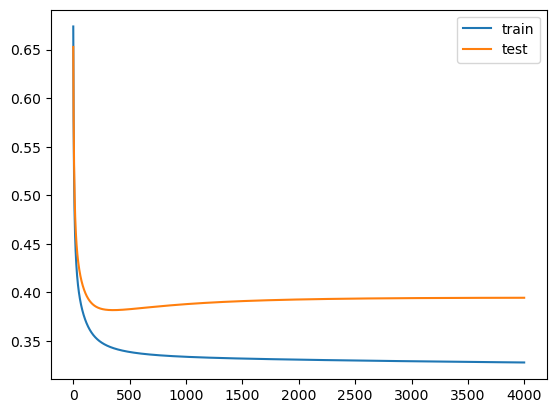

In [1283]:
sns.lineplot(train_losses, label="train")
sns.lineplot(test_losses, label="test")

Accuracy: 0.770370364189148


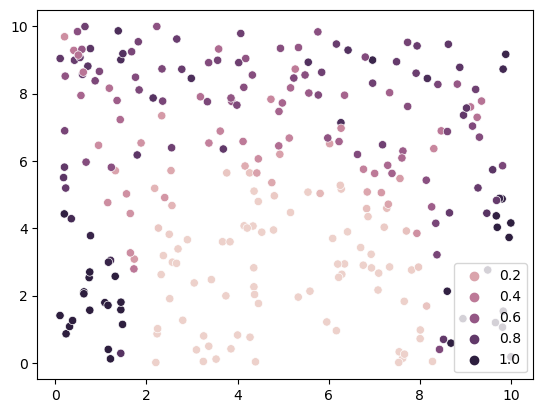

In [1284]:
test_data, labels, test_dists = next(
    iter(DataLoader(test_dataset, batch_size=len(test_dataset)))
)
with torch.no_grad():
    y_test = model(test_data).flatten()
    sns.scatterplot(x=test_dists[:, 0], y=test_dists[:, 1], hue=y_test[:])
    # plt.axhline(class_sigma_threshold)

print(f"Accuracy: {BinaryAccuracy()(y_test, labels)}")

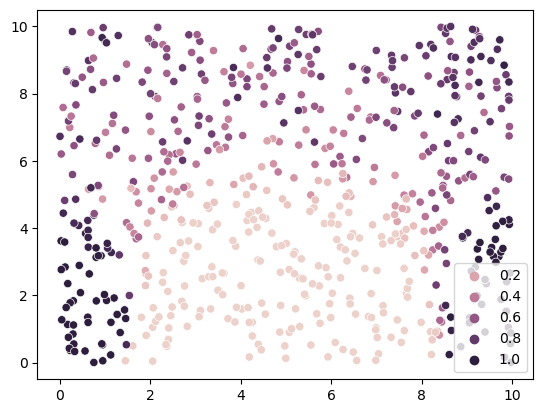

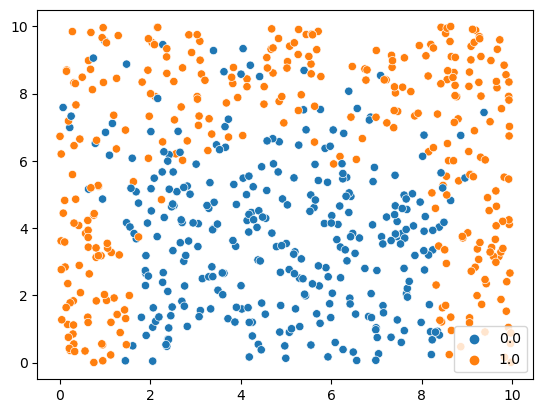

Accuracy: 0.8190476298332214


In [1285]:
train_data, labels, train_dists = next(
    iter(DataLoader(train_dataset, batch_size=len(train_dataset)))
)
with torch.no_grad():
    y_train = model(train_data).flatten()
    plot = sns.scatterplot(
        x=train_dists[:, 0], y=train_dists[:, 1], hue=y_train[:])
    # plt.axhline(class_sigma_threshold)
    plt.show()
    plot = sns.scatterplot(
        x=train_dists[:, 0], y=train_dists[:, 1], hue=torch.round(y_train[:])
    )
    # plt.axhline(class_sigma_threshold)
    plt.show()
print(f"Accuracy: {BinaryAccuracy()(y_train, labels)}")

In [1181]:
rff_encoder = RffEncoder(
    n_features, n_dim, kernel=kernel, coeff=coeff, lengthscale=lengthscale
)
rff_encoder.gen_features()

mean_embeddings = gen_mean_embeddings(normal_samples, rff_encoder)

dataset = DistributionDataset(mean_embeddings, normal_labels, normal_dists)

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_ratio, 1 - train_ratio]
)

model = LogisticRegression(n_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

_, test_losses = train_model(
    model, optimizer, train_dataset, test_dataset, 2000)

test_data, labels, _ = next(
    iter(DataLoader(test_dataset, batch_size=len(test_dataset)))
)
with torch.no_grad():
    y_test = model(test_data).flatten()
print(f"Accuracy: {BinaryAccuracy()(y_test, labels)}")